<a href="https://colab.research.google.com/github/pitohui7456/Detecting-pneumonia-with-CNN/blob/main/%EC%A0%84%EC%B2%98%EB%A6%AC%EC%A0%81%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:
import keras
keras.__version__

'2.4.3'

In [ ]:
!unzip /content/drive/My\ Drive/새출발/png_조정.zip -d /content

In [ ]:
import numpy as np
import cv2  

In [ ]:
np.random.seed(100)

In [ ]:
def adjust_gamma(image, gamma=2):
   table = np.array([((i / 255.0) ** gamma) * 255
                     for i in np.arange(0, 256)]).astype("uint8")
   # apply gamma correction using the lookup table
   return cv2.LUT(image, table)

In [ ]:
import os
os.mkdir('/content/test')
os.mkdir('/content/test/nor')
os.mkdir('/content/test/pneu')

os.mkdir('/content/train')
os.mkdir('/content/train/nor')
os.mkdir('/content/train/pneu')

In [ ]:
for img_name in os.listdir('/content/폐렴png_조정/'):
    image_path='/content/폐렴png_조정/'+img_name
    #print(img_name)
    dst='/content/train/pneu/'+img_name
    img = cv2.imread(image_path,0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img2 = clahe.apply(img)
    img2 = adjust_gamma(img2,2)
    img3 = cv2.resize(img2,(256,256))

    #cv2_imshow(img3)
    cv2.imwrite(dst,img3)

for img_name in os.listdir('/content/정상png_조정/'):
    image_path='/content/정상png_조정/'+img_name
    #print(img_name)
    dst='/content/train/nor/'+img_name
    img = cv2.imread(image_path,0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img2 = clahe.apply(img)
    img2 = adjust_gamma(img2,2)
    img3 = cv2.resize(img2,(256,256))

    #cv2_imshow(img3)
    cv2.imwrite(dst,img3)

In [ ]:
import shutil
i=0
for name in os.listdir('/content/train/nor'):
  src='/content/train/nor/'+name
  dst='/content/test/nor/'+name
  shutil.move(src,dst)
  i+=1
  if i>1423:
    break

i=0
for name in os.listdir('/content/train/pneu'):
  src='/content/train/pneu/'+name
  dst='/content/test/pneu/'+name
  shutil.move(src,dst)
  i+=1
  if i>800:
    break

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,zoom_range=0.05,rotation_range=3,shear_range=0.01,height_shift_range=0.03,width_shift_range=0.02, fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory('/content/train',target_size=(256, 256),batch_size=32,color_mode='grayscale',class_mode='binary')
test_generator =test_datagen.flow_from_directory('/content/test',target_size=(256, 256),batch_size=32,color_mode='grayscale',class_mode='binary')

Found 12000 images belonging to 2 classes.
Found 2225 images belonging to 2 classes.


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.initializers  import VarianceScaling, glorot_normal
from keras.optimizers import Adam

In [ ]:
#모델 생성
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(256,256,1), kernel_initializer=VarianceScaling(scale=2.0,distribution='normal')))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(64,kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', kernel_initializer=VarianceScaling(scale=2.0,distribution='normal'))) 
model.add(MaxPooling2D(pool_size=(3,3), strides=(3,3)))
model.add(Conv2D(64,kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', kernel_initializer=VarianceScaling(scale=2.0,distribution='normal'))) 
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(128,kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', kernel_initializer=VarianceScaling(scale=2.0,distribution='normal'))) 
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(256,kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', kernel_initializer=VarianceScaling(scale=2.0,distribution='normal'))) 
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(512,kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', kernel_initializer=VarianceScaling(scale=2.0,distribution='normal')))
model.add(GlobalAveragePooling2D(data_format='channels_last'))
model.add(Dense(512, activation='relu', kernel_initializer=VarianceScaling(scale=2.0,distribution='normal')))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu', kernel_initializer=VarianceScaling(scale=2.0,distribution='normal')))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu', kernel_initializer=VarianceScaling(scale=2.0,distribution='normal')))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer=VarianceScaling(scale=2.0,distribution='normal')))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', kernel_initializer=glorot_normal()))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.000009), metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
%%time
history = model.fit(train_generator,steps_per_epoch=375 , epochs=50, validation_data=test_generator, validation_steps=70, verbose=1)

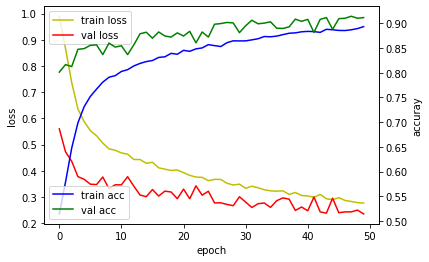

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
#CLAHE & gamma correction 적용
for img_name in os.listdir('/content/폐렴png_test_조정/'):
    image_path='/content/폐렴png_test_조정/'+img_name
    #print(img_name)
    dst='/content/test/pneu/'+img_name
    img = cv2.imread(image_path,0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img2 = clahe.apply(img)
    img2 = adjust_gamma(img2,2)
    img3 = cv2.resize(img2,(256,256))

    #cv2_imshow(img3)
    cv2.imwrite(dst,img3)

#CLAHE & gamma correction 적용
for img_name in os.listdir('/content/정상png_test_조정/'):
    image_path='/content/정상png_test_조정/'+img_name
    #print(img_name)
    dst='/content/test/nor/'+img_name
    img = cv2.imread(image_path,0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img2 = clahe.apply(img)
    img2 = adjust_gamma(img2,2)
    img3 = cv2.resize(img2,(256,256))

    #cv2_imshow(img3)
    cv2.imwrite(dst,img3)

In [ ]:
test_generator =test_datagen.flow_from_directory('/content/test',target_size=(256, 256),batch_size=32,color_mode='grayscale',class_mode='binary')

Found 2861 images belonging to 2 classes.


In [ ]:
score =model.evaluate_generator(test_generator)
print("test %s: %.2f%%   test %s: %.2f%%" %(model.metrics_names[1], score[1]*100,model.metrics_names[0],score[0]*100))

test accuracy: 88.29%   test loss: 31.28%


In [ ]:
#모델 저장
model_json = model.to_json()
with open("/content/drive/My Drive/성능테스트/전처리모델2.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
#가중치 저장
model.save_weights("/content/drive/My Drive/성능테스트/전처리모델2.h5")

In [ ]:
#모델 로드
from keras.models import model_from_json 
json_file = open("/content/drive/My Drive/성능테스트/전처리모델.json", "r") 
loaded_model_json = json_file.read() 
json_file.close() 
model = model_from_json(loaded_model_json)

In [ ]:
model.load_weights("/content/drive/My Drive/성능테스트/전처리모델2.h5") 
print("Loaded model from disk")

Loaded model from disk


In [ ]:
!unzip /content/drive/My\ Drive/새출발/광저우어린이.zip -d /content

In [ ]:
import os

In [ ]:
os.mkdir('/content/test어린이')
os.mkdir('/content/test어린이/pneu')
os.mkdir('/content/test어린이/nor')

In [ ]:
#광저우 어린이 이미지 전처리 후 복사
k=0
#CLAHE & gamma correction 적용
for img_name in os.listdir('/content/PNEUMONIA/'):
    image_path='/content/PNEUMONIA/'+img_name
    #print(img_name)
    dst='/content/test어린이/pneu/'+img_name
    img = cv2.imread(image_path,0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img2 = clahe.apply(img)
    img2 = adjust_gamma(img2,2)
    img3 = cv2.resize(img2,(256,256))

    #cv2_imshow(img3)
    cv2.imwrite(dst,img3)
    k+=1
    if k>1073:
      break

for img_name in os.listdir('/content/NORMAL/'):
    image_path='/content/NORMAL/'+img_name
    #print(img_name)
    dst='/content/test어린이/nor/'+img_name
    img = cv2.imread(image_path,0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img2 = clahe.apply(img)
    img2 = adjust_gamma(img2,2)
    img3 = cv2.resize(img2,(256,256))

    #cv2_imshow(img3)
    cv2.imwrite(dst,img3)

In [ ]:
test_generator =test_datagen.flow_from_directory('/content/test어린이',target_size=(256, 256),batch_size=32,color_mode='grayscale',class_mode='binary')
score =model.evaluate_generator(test_generator)
print("test %s: %.2f%%   test %s: %.2f%%" %(model.metrics_names[1], score[1]*100,model.metrics_names[0],score[0]*100))

Found 2657 images belonging to 2 classes.
test accuracy: 64.73%   test loss: 84.56%


In [ ]:
for i in range(3):
  os.mkdir('/content/child'+str(i+1))
  os.mkdir('/content/child'+str(i+1)+'/nor')
  os.mkdir('/content/child'+str(i+1)+'/pneu')

In [ ]:
#박테리아성, 바이러스성 폐렴 이미지 전처리 후 저장
for i in os.listdir('/content/PNEUMONIA'):
  src='/content/PNEUMONIA/'+i
  dst1='/content/child1/pneu/'+i
  dst2='/content/child2/pneu/'+i
  img = cv2.imread(src,0)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  img2 = clahe.apply(img)
  img2 = adjust_gamma(img2,2)
  img3 = cv2.resize(img2,(256,256))
  if i.find('bac',5) != -1:   
    cv2.imwrite(dst1,img3)
  elif i.find('vir',5) != -1:
    cv2.imwrite(dst2,img3)

In [ ]:
print(len(os.listdir('/content/child1/pneu')))
print(len(os.listdir('/content/child2/pneu')))

2780
1493


In [ ]:
#정상 전처리 후 저장
for i in os.listdir('/content/NORMAL'):
  src='/content/NORMAL/'+i
  dst='/content/child3/nor/'+i
  
  img = cv2.imread(src,0)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  img2 = clahe.apply(img)
  img2 = adjust_gamma(img2,2)
  img3 = cv2.resize(img2,(256,256))
  cv2.imwrite(dst,img3)

In [ ]:
for i in range(3):
  path='/content/child'+str(i+1)
  test_generator =test_datagen.flow_from_directory(path,target_size=(256, 256),batch_size=32,color_mode='grayscale',class_mode='binary')
  score =model.evaluate_generator(test_generator)
  print("test %s: %.2f%%   test %s: %.2f%%" %(model.metrics_names[1], score[1]*100,model.metrics_names[0],score[0]*100))

Found 2780 images belonging to 2 classes.
test accuracy: 96.91%   test loss: 8.66%
Found 1493 images belonging to 2 classes.
test accuracy: 94.78%   test loss: 14.13%
Found 1583 images belonging to 2 classes.
test accuracy: 42.70%   test loss: 135.30%


In [ ]:
fpath='/content/random_sample'
for i in range(10):
  os.mkdir(fpath+str(i+1))
  os.mkdir(fpath+str(i+1)+'/nor')
  os.mkdir(fpath+str(i+1)+'/pneu')

In [ ]:
import random
random.seed(100)

In [ ]:
print(len(os.listdir('/content/test/nor')))
print(len(os.listdir('/content/test/pneu')))

1704
1157


In [ ]:
#랜덤 샘플링 
for i in range(10):
  src_list=random.sample(os.listdir('/content/test/nor'),595)
  for j in range(595):
    src='/content/test/nor/'+src_list[j]
    dst='/content/random_sample'+str(i+1)+'/nor/'+src_list[j]
    shutil.copyfile(src,dst)
    
  for k in range(405):
    src='/content/test/pneu/'+random.choice(os.listdir('/content/test/pneu'))
    dst='/content/random_sample'+str(i+1)+'/pneu/'+src_list[k]
    shutil.copy(src,dst)
  
  path='/content/random_sample'+str(i+1)
  test_generator =test_datagen.flow_from_directory(path,target_size=(256, 256),batch_size=32,color_mode='grayscale',class_mode='binary')
  score =model.evaluate_generator(test_generator)
  print("test %s: %.2f%%   test %s: %.2f%%" %(model.metrics_names[1], score[1]*100,model.metrics_names[0],score[0]*100))

Found 1000 images belonging to 2 classes.
test accuracy: 87.90%   test loss: 32.40%
Found 1000 images belonging to 2 classes.
test accuracy: 88.10%   test loss: 32.38%
Found 1000 images belonging to 2 classes.
test accuracy: 89.10%   test loss: 30.05%
Found 1000 images belonging to 2 classes.
test accuracy: 88.10%   test loss: 31.45%
Found 1000 images belonging to 2 classes.
test accuracy: 88.10%   test loss: 31.95%
Found 1000 images belonging to 2 classes.
test accuracy: 87.40%   test loss: 35.07%
Found 1000 images belonging to 2 classes.
test accuracy: 87.00%   test loss: 33.23%
Found 1000 images belonging to 2 classes.
test accuracy: 87.80%   test loss: 31.96%
Found 1000 images belonging to 2 classes.
test accuracy: 88.10%   test loss: 30.38%
Found 1000 images belonging to 2 classes.
test accuracy: 86.80%   test loss: 34.34%


In [ ]:
#87.84